# Quantum Approximate Optimization Algorithm using Analog QC

This notebook implements Quantum Approximate Optimization Algorithm (QAOA) on a analog Quantum Computing model.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

# Utility imports
import networkx as nx
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
import time


In [2]:
# Defining some helper functions.
# Graph plotting function.
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

# Plotting the resulting set S as coloring on the graph.
def plot_solution(G,pos,results):
    c = ["r" if b == "0" else "c" for b in find_most_common_solutions(results, 1)[0]]
    draw_graph(G, c, pos)

# Plotting the distribution of the state.
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

Suppose we are given the following QUBO matrix $Q$:

I wrote a function to generate $Q$ from a graph instance.

In [3]:
def generate_Q(G):
    '''Funtion to generate Q given a Graph G.'''

    model = Model()
    x = model.binary_var_list(n)
    Q = sum(-1*x[e[0]]*x[e[1]] for e in edges) + sum(x[v] for v in G.nodes())
    model.minimize(Q)   

    problem = from_docplex_mp(model)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    q_ij = -1*quadratics.toarray()
    c_ii = -1*linears.toarray()

    np.fill_diagonal(q_ij,c_ii)

    for ((i,j),val) in np.ndenumerate(q_ij):
        if j<i:
            q_ij[i,j] = q_ij[j,i]

    return q_ij

The cost Hamiltonian encodes the objective function of the optimization problem you want to solve. It's typically a sum of terms, each associated with a specific constraint or cost in your optimization problem. The terms in H_C are represented as a weighted sum of Pauli-Z operators acting on one or more qubits. The weights represent the cost or penalty associated with violating the corresponding constraints.

### Embedding a QUBO onto an atomic register

We have to embed $Q$ into a neutral-atom device. 

The key idea is to encode the off-diagonal terms of $Q$ by using the Rydberg interaction between atoms. As the interaction $U$ depends on the pairwise distance ($U=C_6/r_{ij}^6$) between atoms $i$ and $j$, we attempt to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

## Building the quantum algorithm 

Now that the QUBO $Q$ is encoded in the Register, we can peprare the following Ising Hamiltonian $H_Q$:

$$ H_Q= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j \lt i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j. $$

In the case where our mapping of the atoms is perfect, the last sum replicates exactly the off-diagonal terms of $Q$. In that case, the next step is to prepare the ground-state of $H_Q$ to output the optimal bitstrings.

To do so we present two different approaches, namely the Quantum Approximation Optimization Algorithm (QAOA) and the Quantum Adiabatic Algorithm (QAA) that have been introduced to prepare ground-states of Hamiltonians.

## QAOA

Now that the QUBO $Q$ is encoded in the Register, we can peprare the following Ising Hamiltonian $H_Q$:

$$ H_Q= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j \lt i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j. $$

In the case where our mapping of the atoms is perfect, the last sum replicates exactly the off-diagonal terms of $Q$. In that case, the next step is to prepare the ground-state of $H_Q$ to output the optimal bitstrings.

To do so we present two different approaches, namely the Quantum Approximation Optimization Algorithm (QAOA) and the Quantum Adiabatic Algorithm (QAA) that have been introduced to prepare ground-states of Hamiltonians.

Once we have the parameters that we want to apply, we use the `.build()` method to assign these values into a `assigned_seq` sequence. It is this sequence which is simulated every time the quantum loop is called.

Experimentally, we don't have access to the state vector $|\psi\rangle$. We therefore make it more realistic by taking samples from the state vector that results from running the simulation with `simul.run()`. This is done with the built-in method `results.sample_final_state()`, in which we add the measurement basis which was declared at the end of the sequence, and the number of samples desired. Currently, the repetition rate of the machine is $5$ Hz.

## Optimization 

We estimate the cost of a sampled state vector by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating

$$
C({\bf z}) = {\bf z}^\top \cdot Q \cdot {\bf z}
$$

Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

To perform a minimization loop, we define the following function that will be called at each step by SciPy. `*args` enables to pass the QUBO value, and `params` contains the trial value to score, which changes at each step.

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the QUBO $Q$ and an initial point `x0` for the simplex in Nelder-Mead minimization. As the optimizer might get trapped in local minima, we repeat the optimization 20 times and select the parameters that yield the best approximation ratio.

QAOA is capable of finding good variational parameters $\tau$ and $t$. Now, sampling from this final state $|\psi(t_{f})\rangle$ will return both optimal strings with high probability.

In [4]:
LAYERS = 4

# Funtion to get the cost of a colouring.
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

# Funtion to get the cost of a solution.
def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

# Function for analog QAOA.
def qaoa_analog(G):
    
    draw_coord = 0
    
    # Generating Q matrix
    Q = generate_Q(G)

    def evaluate_mapping(new_coords, *args):
        """Cost function to minimize. Ideally, the pairwise
        distances are conserved"""
        Q, shape = args
        new_coords = np.reshape(new_coords, shape)
        new_Q = squareform(
            DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
        )
        return np.linalg.norm(new_Q - Q)
    
    # Optimizing the co-ordinates
    shape = (len(Q), 2)
    costs = []
    np.random.seed(0)
    x0 = np.random.random(shape).flatten()
    res = minimize(
        evaluate_mapping,
        x0,
        args=(Q, shape),
        method="Nelder-Mead",
        tol=1e-6,
        options={"maxiter": 200000, "maxfev": None},
    )

    coords = np.reshape(res.x, (len(Q), 2))
    qubits = dict(enumerate(coords))
    reg = Register(qubits)
    if draw_coord:
        reg.draw(
            blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
            draw_graph=False,
            draw_half_radius=True,
        )

    LAYERS = 2

    # Parametrized sequence of atoms
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)

    for t, s in zip(t_list, s_list):
        pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
        pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

        seq.add(pulse_1, "ch0")
        seq.add(pulse_2, "ch0")

    seq.measure("ground-rydberg")

    def quantum_loop(parameters):
        params = np.array(parameters)
        t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
        assigned_seq = seq.build(t_list=t_params, s_list=s_params)
        simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
        results = simul.run()
        count_dict = results.sample_final_state()  # sample from the state vector
        return count_dict

    np.random.seed(123)  # ensures reproducibility of the tutorial
    guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
    }

    example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

    def func(param, *args):
        Q = args[0]
        C = quantum_loop(param)
        cost = get_cost(C, Q)
        return cost



    # Optimization Loop - QAOA
    scores = []
    params = []

    times = []
    for repetition in range(20):
        guess = {
            "t": np.random.uniform(1, 10, LAYERS),
            "s": np.random.uniform(1, 10, LAYERS),
        }

        try:
            start_time = time.time()
            res = minimize(
                func,
                args=Q,
                x0=np.r_[guess["t"], guess["s"]],
                method="Nelder-Mead",
                tol=1e-5,
                options={"maxiter": 10},
            )
            end_time = time.time()
            times.append(end_time - start_time)
            scores.append(res.fun)
            params.append(res.x)
        except Exception as e:
            pass

    print(f"Mean time for minimization: {np.mean(times)}")

    # Selecting the best QAOA Result
    optimal_count_dict = quantum_loop(params[np.argmin(scores)])
    
    return optimal_count_dict, plot_distribution(optimal_count_dict)

## Running QAOA for MIS on neutral atoms. 

### Graph with 3 nodes

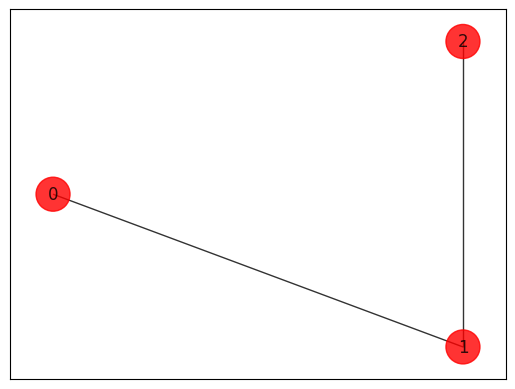

In [5]:
# Initializing a Graph Instance.

# Generating a graph of 3 nodes
# Nodes in the Graph.
n = 3  # Number of nodes in graph
G3 = nx.Graph()
G3.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0)]
G3.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G3.nodes()]
pos_3 = nx.shell_layout(G3)

draw_graph(G3, colors, pos_3)

Mean time for minimization: 0.7160524606704712


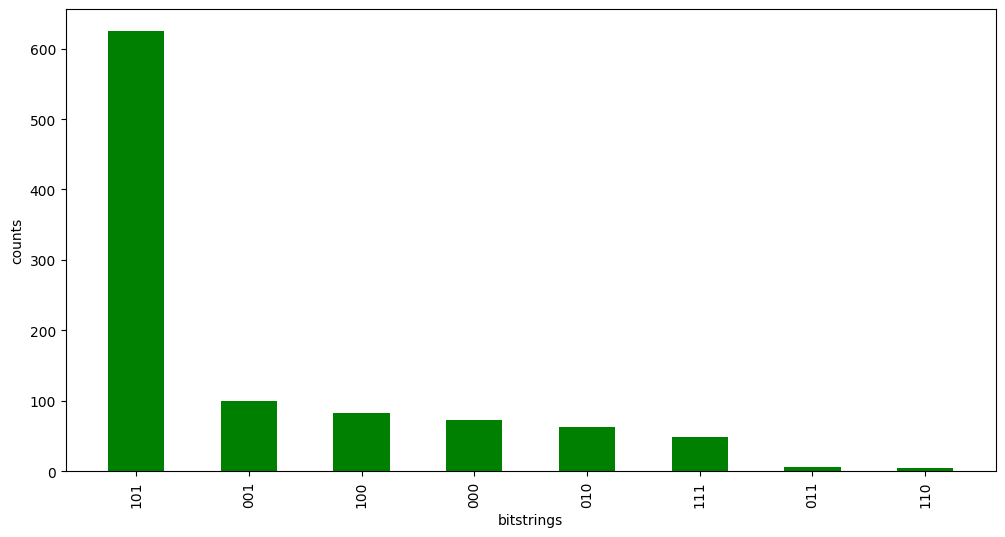

In [6]:
counts_3, hist_3 = qaoa_analog(G3)
hist_3

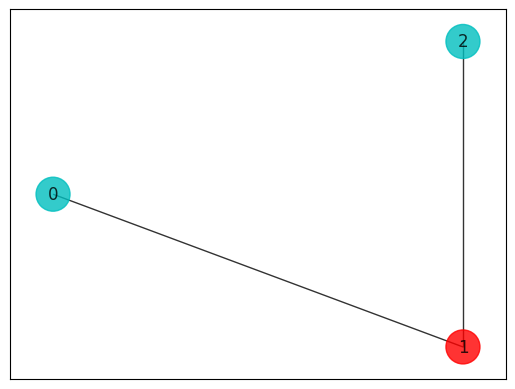

In [7]:
plot_solution(G3,pos_3,counts_3)

### Graph with 4 nodes

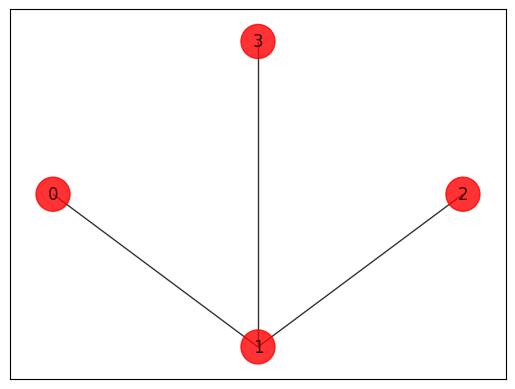

In [8]:
# Initializing a Graph Instance.

# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 4  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (1, 3, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G4.nodes()]
pos_4 = nx.shell_layout(G4)

draw_graph(G4, colors, pos_4)

Mean time for minimization: 0.758564567565918


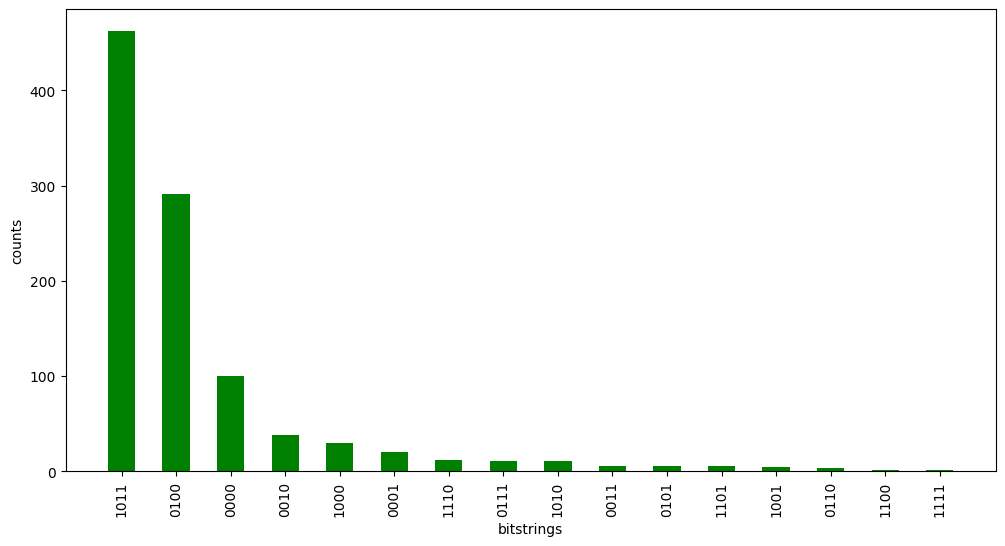

In [9]:
counts_4, hist_4 = qaoa_analog(G4)
hist_4

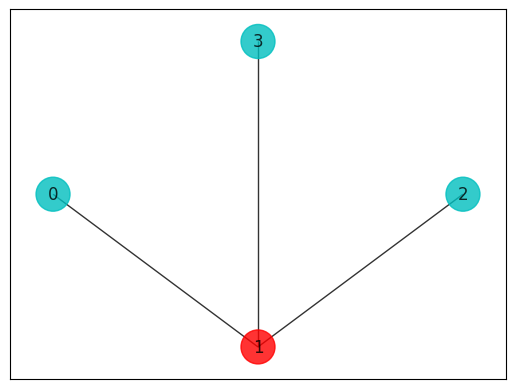

In [10]:
plot_solution(G4,pos_4,counts_4)

### Graph with 5 nodes

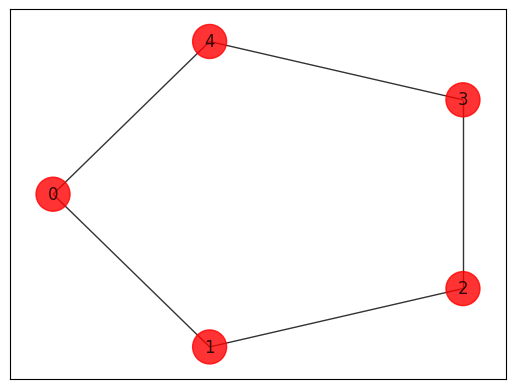

In [11]:
# Initializing a Graph Instance.

# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 5  # Number of nodes in graph
G5 = nx.Graph()
G5.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 0, 1.0)]
G5.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G5.nodes()]
pos_5 = nx.shell_layout(G5)

draw_graph(G5, colors, pos_5)

Mean time for minimization: 1.0206553101539613


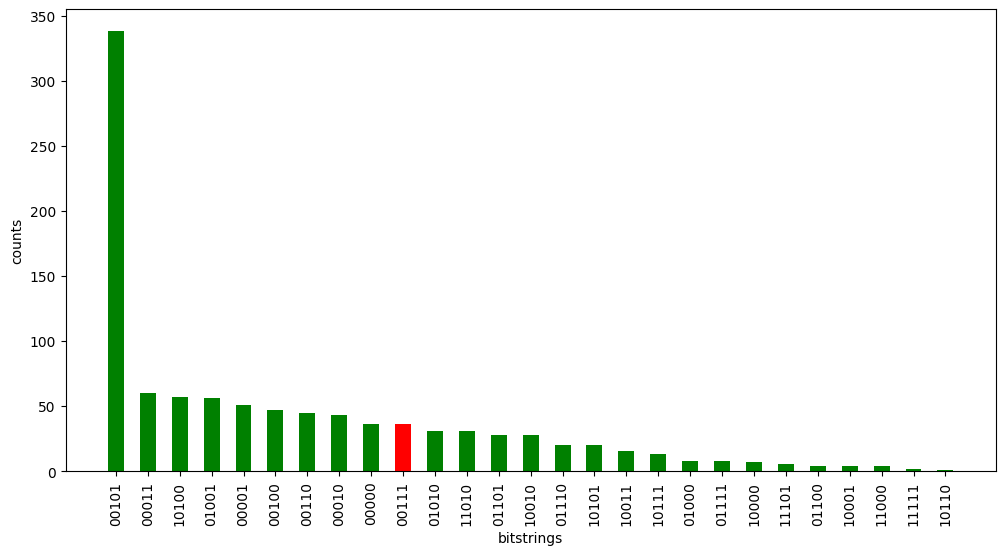

In [12]:
counts_5, hist_5 = qaoa_analog(G5)
hist_5

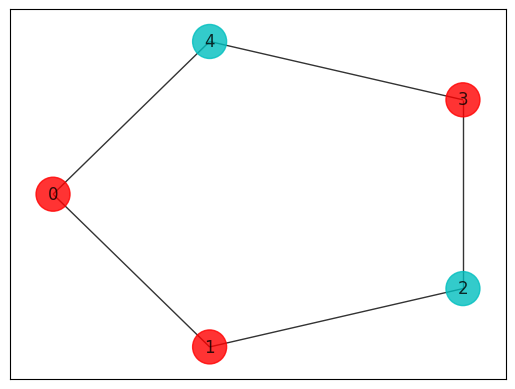

In [13]:
plot_solution(G5,pos_5,counts_5)

### Graph with 6 nodes

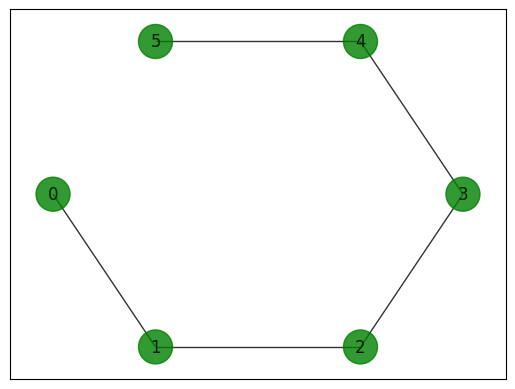

In [14]:
# Initializing a Graph Instance.

# Defining the Graph.
# Nodes in the Graph.
n = 6  
G6 = nx.Graph()
G6.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0)]
G6.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["g" for node in G6.nodes()]
pos6 = nx.shell_layout(G6)

draw_graph(G6, colors, pos6)

Mean time for minimization: 1.2036117911338806


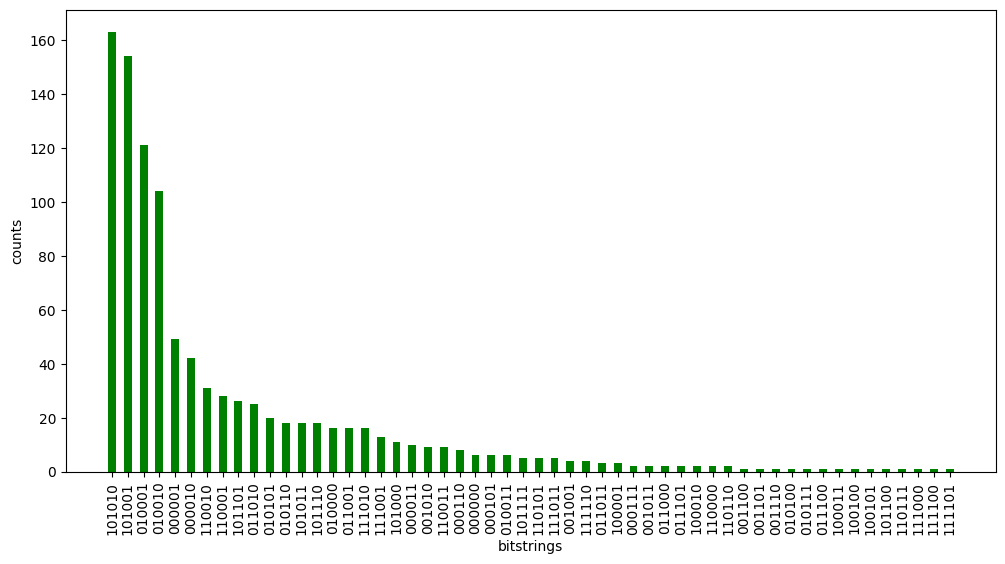

In [15]:
counts_6, hist_6 = qaoa_analog(G6)
hist_6

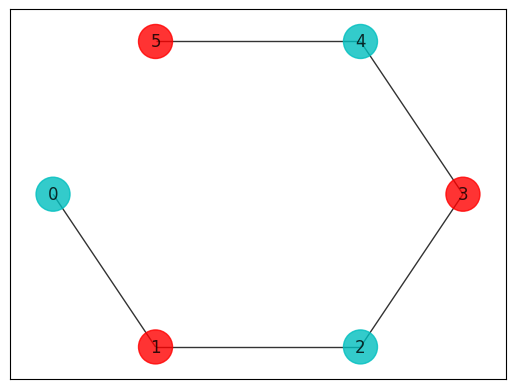

In [16]:
plot_solution(G6,pos6,counts_6)

### Graph with 7 nodes

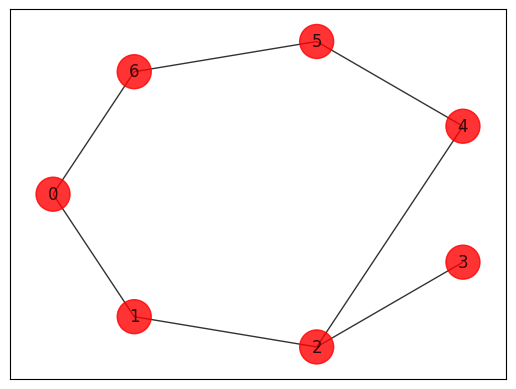

In [17]:
# Generating a graph of 7 nodes

# Defining the Graph.
# Nodes in the Graph.
n = 7  
G7 = nx.Graph()
G7.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 4, 1.0), (2, 3, 1.0), (4, 5, 1.0), (5, 6, 1.0), (0, 6, 1.0)]
G7.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G7.nodes()]
pos7 = nx.shell_layout(G7)

draw_graph(G7, colors, pos7)

Mean time for minimization: 1.7078204870223999


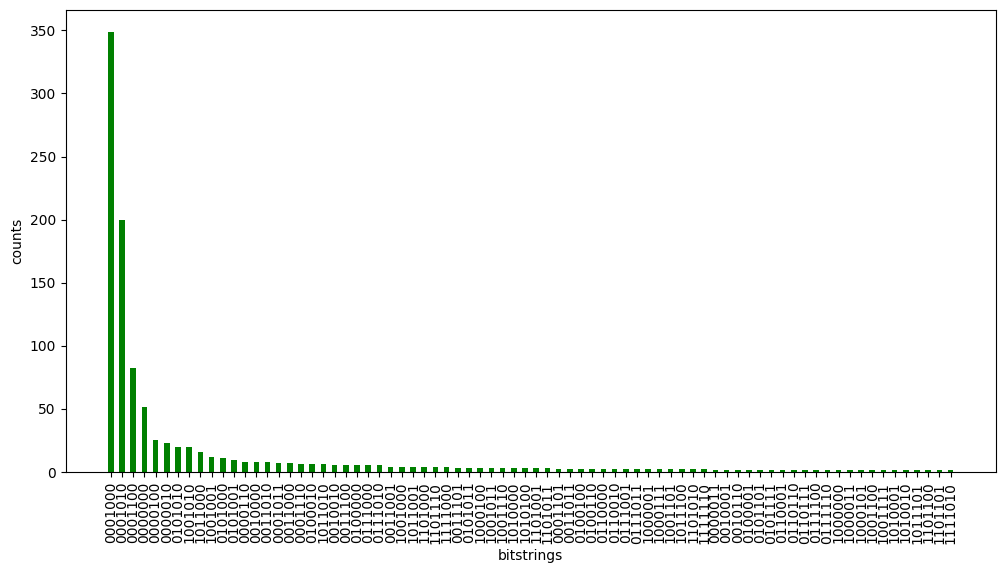

In [18]:
counts_7, hist_7 = qaoa_analog(G7)
hist_7

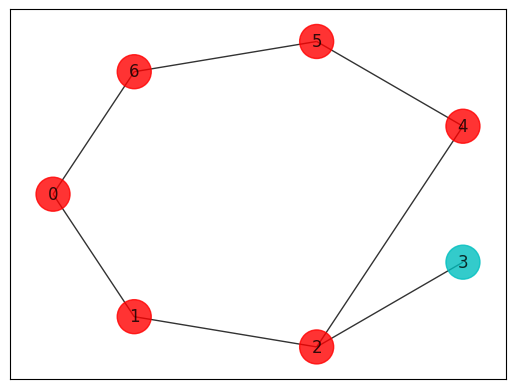

In [19]:
plot_solution(G7,pos7,counts_7)